In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

from torchts.nn.loss import quantile_loss
from torchts.nn.model import TimeSeriesModel

# Set random seed for reproducibility

In [2]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Generate data

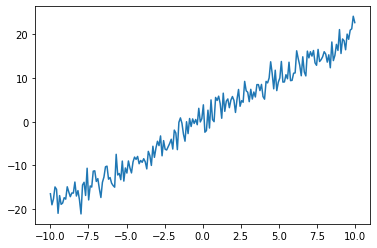

In [3]:
# generate linear time series data with some noise
n = 200
x_max = 10
slope = 2
scale = 2

x = torch.from_numpy(np.linspace(-x_max, x_max, n).reshape(-1, 1).astype(np.float32))
y = slope * x + np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)

plt.plot(x, y)
plt.show()

### Make test set

In [4]:
# Make test set
x_test = x
y_test = 2 * x

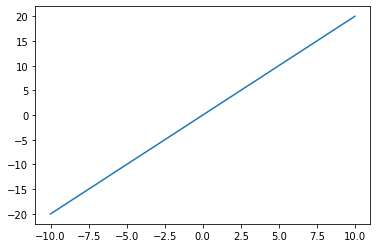

In [5]:
plt.plot(x, y_test)
plt.show()

# Define model that predicts quantiles

In [6]:
class QuantileLSTM(TimeSeriesModel):
    def __init__(
        self, input_size, output_size, hidden_size, optimizer, quantile=0.5, **kwargs
    ):
        super().__init__(
            optimizer,
            criterion=quantile_loss,
            criterion_args={"quantile": quantile},
            **kwargs
        )
        n_quantiles = 1 if isinstance(quantile, float) else len(quantile)
        self.lstm = nn.ModuleList(
            [nn.LSTMCell(input_size, hidden_size) for _ in range(output_size)]
        )
        self.linear = nn.ModuleList(
            [nn.Linear(hidden_size, n_quantiles) for _ in range(output_size)]
        )

    def forward(self, x, y=None, batches_seen=None):
        hidden, _ = zip(*[m(x) for m in self.lstm])
        out = [m(h) for m, h in zip(self.linear, hidden)]
        return torch.hstack(out)

In [7]:
input_size = 1
output_size = 1
hidden_size = 16
quantile = 0.5
optimizer = optim.Adam
optimizer_args = {"lr": 0.005}
max_epochs = 100
batch_size = 10

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    optimizer_args=optimizer_args,
)

In [82]:
n

200

In [144]:
# Split our training dataset into training and calibration sets randomly
# and correct to maintain the timeseries convention of ascending x
idx = np.random.permutation(n)
n_half = int(np.floor(n/2))
idx_train, idx_cal = np.sort(idx[:n_half]), np.sort(idx[n_half:2*n_half])

In [148]:
# Perform split using our split indices
x_train = x.numpy()[idx_train]
x_cal = x.numpy()[idx_cal]

y_train = y.numpy()[idx_train]
y_cal = y.numpy()[idx_cal]

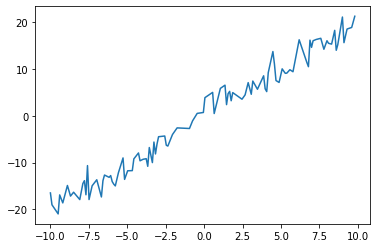

In [149]:
plt.plot(torch.tensor(x_train), torch.tensor(y_train))
plt.show()

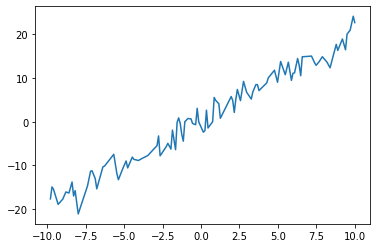

In [150]:
plt.plot(torch.tensor(x_cal), torch.tensor(y_cal))
plt.show()

# Train model to predict a single quantile

In [8]:
# train model
model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# inference
y_preds = model.predict(x)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\mlabr\anaconda3\envs\spatiotemporal\lib\site-packages\pytorch_lightning\trainer\trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(
C:\Users\mlabr\anaconda3\envs\spatiotemporal\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 1.2 K 
1 | linear | ModuleList | 17    
--------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
C:\Users\mlabr\anaconda3\en

Epoch 99: 100%|██████████| 20/20 [00:00<00:00, 327.85it/s, loss=0.815, v_num=3, train_loss_step=0.681, train_loss_epoch=0.815]


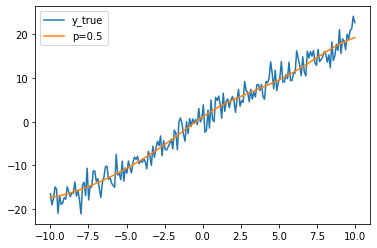

In [9]:
plt.plot(x, y, label="y_true")
plt.plot(x, y_preds, label=f"p={quantile}")
plt.legend()
plt.show()

# Train model to predict multiple quantiles

In [10]:
quantile = [0.025, 0.5, 0.975]

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    optimizer_args=optimizer_args,
)

In [11]:
# train model
model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# inference
y_preds = model.predict(x)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\mlabr\anaconda3\envs\spatiotemporal\lib\site-packages\pytorch_lightning\trainer\trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(
C:\Users\mlabr\anaconda3\envs\spatiotemporal\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 1.2 K 
1 | linear | ModuleList | 51    
--------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
C:\Users\mlabr\anaconda3\en

Epoch 99: 100%|██████████| 20/20 [00:00<00:00, 232.56it/s, loss=1.03, v_num=4, train_loss_step=0.981, train_loss_epoch=1.030] 


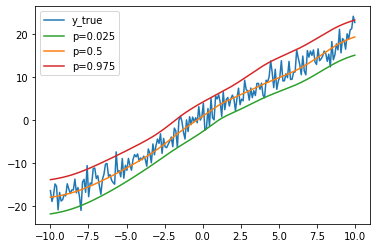

In [12]:
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x, y, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()
plt.show()

### Begin implementation of conformal prediction code

In [13]:
def quantile_err(prediction, y):
    """
    prediction: arr where first 3 columns are: lower quantile, middle quantile (50%), upper quantile in that order
    """
    y_lower = prediction[:, 0]
    y_upper = prediction[:, 2]
    # Calculate error on our predicted upper and lower quantiles
    # this will get us an array of negative values with the distance between the upper/lower quantile and the
    # 50% quantile
    error_low = y_lower - y
    error_high = y - y_upper
    # Make an array where each entry is the highest error when comparing the upper and lower bounds for that entry prediction 
    err = np.maximum(error_high, error_low)
    return err

In [14]:
# Find quantile error of our model
quantile_err(y_preds, y_preds[:, 1])

tensor([-3.8695, -3.8646, -3.8595, -3.8540, -3.8481, -3.8419, -3.8353, -3.8283,
        -3.8209, -3.8131, -3.8048, -3.7961, -3.7869, -3.7772, -3.7671, -3.7565,
        -3.7454, -3.7338, -3.7217, -3.7092, -3.6962, -3.6827, -3.6688, -3.6544,
        -3.6396, -3.6245, -3.6089, -3.5929, -3.5766, -3.5599, -3.5430, -3.5257,
        -3.5081, -3.4902, -3.4720, -3.4536, -3.4348, -3.4158, -3.3966, -3.3771,
        -3.3573, -3.3372, -3.3168, -3.2962, -3.2753, -3.2541, -3.2327, -3.2110,
        -3.1890, -3.1669, -3.1445, -3.1219, -3.0992, -3.0765, -3.0536, -3.0308,
        -3.0082, -2.9857, -2.9636, -2.9420, -2.9209, -2.9007, -2.8815, -2.8636,
        -2.8473, -2.8328, -2.8206, -2.8110, -2.8045, -2.8015, -2.8025, -2.8080,
        -2.8182, -2.8336, -2.8542, -2.8801, -2.9112, -2.9469, -2.9867, -3.0298,
        -3.0752, -3.1219, -3.1689, -3.2152, -3.2599, -3.3025, -3.3424, -3.3793,
        -3.4128, -3.4431, -3.4699, -3.4934, -3.5063, -3.4886, -3.4680, -3.4440,
        -3.4163, -3.3845, -3.3484, -3.30

In [15]:
# store our quantile errors into variable named for calibration scores
cal_scores = quantile_err(y_preds, y_preds[:, 1])

In [35]:
# Make a dictionary where our calibration scores (errors) are sorted in descending order
nc = {0: np.sort(cal_scores, 0)[::-1]}

In [44]:
# Specify significance we would like to see for our coverage when dealing with conformal prediction
significance = .9

In [67]:
# Sort calibration scores in ascending order? TODO make sure this is correct
# this is the apply_inverse portion of RegressorNC predict function
nc = np.sort(cal_scores,0)

index = int(np.ceil((1-significance) * (nc.shape[0] + 1))) - 1
# find largest error that gets us guaranteed coverage
index = min(max(index, 0), nc.shape[0] - 1)

err_dist = np.vstack([nc[index], nc[index]])

In [70]:
err_dist

array([[-3.8646412],
       [-3.8646412]], dtype=float32)

In [48]:
# store the predictions from our nonconformal quantile regressor
prediction = y_preds

In [53]:
intervals = np.zeros((x.shape[0],2))
# TODO ensure that we want to multiply our error distances by the size of our training set
err_dist = np.hstack([err_dist] * n)

In [75]:
# CQR

# grab the first and last intervals predicted from our nonconformal quantile regressor in order to
# calculate our new intervals that fit our coverage requirements
intervals[:, 0] = prediction[:,0] - err_dist[0, :]
intervals[:, 1] = prediction[:, -1] + err_dist[1,:]

conformal_intervals = intervals

IndexError: index 2 is out of bounds for axis 1 with size 2

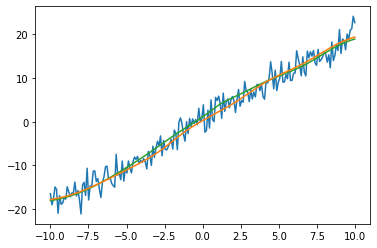

In [76]:
# n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x, y, label="y_true")

for i, c in zip(range(len(conformal_intervals)), color_index):
    plt.plot(x, conformal_intervals[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()
plt.show()

# End of conformal implementation

# Add second response variable

In [ ]:
# y_max = slope * x_max
# y2 = 2 * y_max / (1 + np.exp(-x)) - y_max
# y2 += np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)
# y = torch.hstack([y, y2])

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(x, y[:, 0])
# plt.subplot(1, 2, 2)
# plt.plot(x, y[:, 1])
# plt.show()

# Train model to predict quantiles for two response variables

In [ ]:
# output_size = 2

# model = QuantileLSTM(
#     input_size,
#     output_size,
#     hidden_size,
#     optimizer,
#     quantile=quantile,
#     optimizer_args=optimizer_args,
# )

In [ ]:
# # train model
# model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# # inference
# y_preds = model.predict(x)

In [ ]:
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(x, y[:, 0], label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(x, y[:, 1], label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i + n_quantiles], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()

# plt.show()